# Getting Started!

This notebook shows how to get started with Quantus, using a very simple example. For this purpose, we use a LeNet model and MNIST dataset.

- Make sure to have GPUs enabled to speed up computation.

In [ ]:
from IPython.display import clear_output
!pip install torch torchvision captum quantus
clear_output()

In [ ]:
import pathlib
import numpy as np
import pandas as pd
import quantus
import torch
import torchvision
from captum.attr import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Enable GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
clear_output()

## 1) Preliminaries

### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [ ]:
# Load datasets and make loaders.
test_samples = 24
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root='./sample_data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.MNIST(root='./sample_data', train=False, transform=transformer, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True) # num_workers=4,
test_loader = torch.utils.data.DataLoader(test_set, batch_size=200, pin_memory=True)

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/train-images-idx3-ubyte.gz to ./sample_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./sample_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



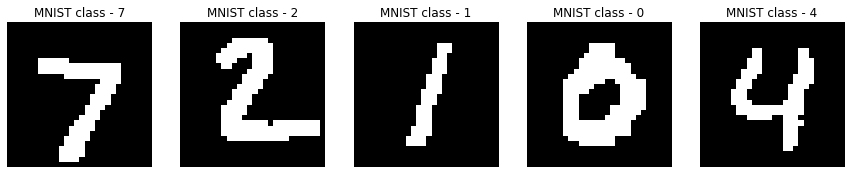

In [ ]:
# Plot some inputs!
nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for i in range(nr_images):
    axes[i].imshow((np.reshape(x_batch[i].cpu().numpy(), (28, 28)) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"MNIST class - {y_batch[i].item()}")
    axes[i].axis("off")
plt.show()

### 1.2 Train a LeNet model

(or any other model of choice). 
Network architecture from: https://github.com/ChawDoe/LeNet5-MNIST-PyTorch.

In [ ]:
class LeNet(torch.nn.Module):
    """Network architecture from: https://github.com/ChawDoe/LeNet5-MNIST-PyTorch."""
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(1, 6, 5)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.relu_1 = torch.nn.ReLU()
        self.conv_2 = torch.nn.Conv2d(6, 16, 5)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.relu_2 = torch.nn.ReLU()
        self.fc_1 = torch.nn.Linear(256, 120)
        self.relu_3 = torch.nn.ReLU()
        self.fc_2 = torch.nn.Linear(120, 84)
        self.relu_4 = torch.nn.ReLU()
        self.fc_3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool_1(self.relu_1(self.conv_1(x)))
        x = self.pool_2(self.relu_2(self.conv_2(x)))
        x = x.view(x.shape[0], -1)
        x = self.relu_3(self.fc_1(x))
        x = self.relu_4(self.fc_2(x))
        x = self.fc_3(x)
        return x

# Load model architecture.
model = LeNet()
print(f"\n Model architecture: {model.eval()}\n")


 Model architecture: LeNet(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_2): ReLU()
  (fc_1): Linear(in_features=256, out_features=120, bias=True)
  (relu_3): ReLU()
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (relu_4): ReLU()
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)



In [ ]:
def train_model(model, 
                train_data: torchvision.datasets,
                test_data: torchvision.datasets, 
                device: torch.device, 
                epochs: int = 20,
                criterion: torch.nn = torch.nn.CrossEntropyLoss(), 
                optimizer: torch.optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9), 
                evaluate: bool = False):
    """Train torch model."""
    
    model.train()
    
    for epoch in range(epochs):

        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)
        
            optimizer.zero_grad()
            
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        # Evaluate model!
        if evaluate:
            predictions, labels = evaluate_model(model, test_data, device)
            test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())
        
        print(f"Epoch {epoch+1}/{epochs} - test accuracy: {(100 * test_acc):.2f}% and CE loss {loss.item():.2f}")

    return model

def evaluate_model(model, data, device):
    """Evaluate torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

In [ ]:
# Train and evaluate model.
model = train_model(model=model.to(device),
                    train_data=train_loader,
                    test_data=test_loader,
                    device=device,
                    epochs=10,
                    criterion=torch.nn.CrossEntropyLoss().to(device),
                    optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
                    evaluate=True)

# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_loader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Model test accuracy: {(100 * test_acc):.2f}%")

Epoch 1/10 - test accuracy: 95.24% and CE loss 0.16
Epoch 2/10 - test accuracy: 96.64% and CE loss 0.06
Epoch 3/10 - test accuracy: 97.99% and CE loss 0.05
Epoch 4/10 - test accuracy: 98.28% and CE loss 0.20
Epoch 5/10 - test accuracy: 98.41% and CE loss 0.08
Epoch 6/10 - test accuracy: 98.74% and CE loss 0.02
Epoch 7/10 - test accuracy: 98.65% and CE loss 0.05
Epoch 8/10 - test accuracy: 98.70% and CE loss 0.03
Epoch 9/10 - test accuracy: 98.92% and CE loss 0.05
Epoch 10/10 - test accuracy: 98.85% and CE loss 0.04
Model test accuracy: 98.85%


### 1.3 Generate explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `quantus.explain` functionality (a simple wrapper around `captum`) however use whatever approach or library you'd like to create your explanations.

In [ ]:
# Generate normalised Saliency and Integrated Gradients attributions of the first batch of the test set.
a_batch_saliency = quantus.normalise_by_negative(Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
a_batch_intgrad = quantus.normalise_by_negative(IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())

# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, a_batch_saliency, a_batch_intgrad]]

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


Visualise attributions given model and pairs of input-output.

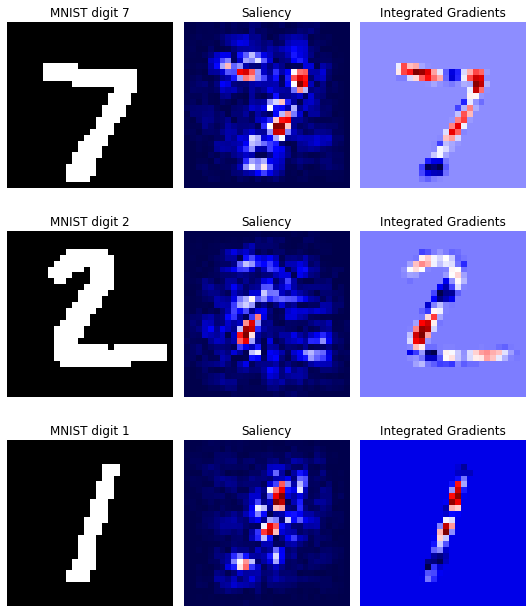

In [ ]:
# Plot explanations!
nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=3, figsize=(nr_images*2.5, int(nr_images*3)))
for i in range(nr_images):
    axes[i, 0].imshow((np.reshape(x_batch[i], (28, 28)) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i, 0].title.set_text(f"MNIST digit {y_batch[i].item()}")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(a_batch_saliency[i], cmap="seismic")
    axes[i, 1].title.set_text(f"Saliency")
    axes[i, 1].axis("off")
    a = axes[i, 2].imshow(a_batch_intgrad[i], cmap="seismic")
    axes[i, 2].title.set_text(f"Integrated Gradients")
    axes[i, 2].axis("off")
plt.tight_layout()
plt.show()

## 2) Quantative evaluation using Quantus

We can evaluate our explanations on a variety of quantuative criteria but as a motivating example we test the Max-Sensitivity (Yeh at el., 2019) of the explanations. This metric tests how the explanations maximally change while subject to slight perturbations.

In [ ]:
# Define metric for evaluation.
metric_init = quantus.MaxSensitivity(nr_samples=10,
    lower_bound=0.1,
    norm_numerator=quantus.fro_norm,
    norm_denominator=quantus.fro_norm,
    perturb_func=quantus.uniform_noise,
    similarity_func=quantus.difference,
    disable_warnings=True,
    normalise=True,
    abs=True,)

In [ ]:
# Return Max-Sensitivity scores for Saliency.
scores_saliency = metric_init(model=model, 
                                  x_batch=x_batch,
                                  y_batch=y_batch,
                                  a_batch=a_batch_intgrad,
                                  device=device,
                                  explain_func=quantus.explain,
                                  explain_func_kwargs={"method": "Saliency"})

In [ ]:
# Return Max-Sensitivity scores for Integrated Gradients.
scores_intgrad = metric_init(model=model, 
                            x_batch=x_batch,
                            y_batch=y_batch,
                            a_batch=a_batch_intgrad,
                            device=device,
                            explain_func=quantus.explain,
                            explain_func_kwargs={"method": "IntegratedGradients"})

In [ ]:
print(f"max-Sensitivity scores by Yeh et al., 2019\n" \
      f"\n • Saliency = {np.mean(scores_saliency):.2f} ({np.std(scores_saliency):.2f})." \
      f"\n • Integrated Gradients = {np.mean(scores_intgrad):.2f} ({np.std(scores_intgrad):.2f})."
      )

max-Sensitivity scores by Yeh et al., 2019

 • Saliency = 0.56 (0.16).
 • Integrated Gradients = 0.33 (0.08).


In [ ]:
metrics = {"max-Sensitivity": metric_init}

xai_methods = {"Saliency": a_batch_saliency,
               "IntegratedGradients": a_batch_intgrad}

results = quantus.evaluate(metrics=metrics,
                           xai_methods=xai_methods,
                           model=model.cpu(),
                           x_batch=x_batch,
                           y_batch=y_batch,
                           agg_func=np.mean,
                           explain_func=quantus.explain,
                           explain_func_kwargs={"method": "IntegratedGradients", "device": device})

df = pd.DataFrame(results)
df

,Saliency,IntegratedGradients
max-Sensitivity,0.405221,0.33176
